<h1 style="font-size:40px;"><center>Exercise V:<br> GANs
</center></h1>

## Short summary
In this exercise, we will design a generative network to generate the last rgb image given the first image. These folder has **three files**: 
- **configGAN.py:** this involves definitions of all parameters and data paths
- **utilsGAN.py:** includes utility functions required to grab and visualize data 
- **runGAN.ipynb:** contains the script to design, train and test the network 

Make sure that before running this script, you created an environment and **installed all required libraries** such 
as keras.

## The data
There exists also a subfolder called **data** which contains the traning, validation, and testing data each has both RGB input images together with the corresponding ground truth images.


## The exercises
As for the previous lab all exercises are found below.


## The different 'Cells'
This notebook contains several cells with python code, together with the markdown cells (like this one) with only text. Each of the cells with python code has a "header" markdown cell with information about the code. The table below provides a short overview of the code cells. 

| #  |  CellName | CellType | Comment |
| :--- | :-------- | :-------- | :------- |
| 1 | Init | Needed | Sets up the environment|
| 2 | Ex | Exercise 1| A class definition of a network model  |
| 3 | Loading | Needed | Loading parameters and initializing the model |
| 4 | Stats | Needed | Show data distribution | 
| 5 | Data | Needed | Generating the data batches |
| 6 | Debug | Needed | Debugging the data |
| 7 | Device | Needed | Selecting CPU/GPU |
| 8 | Init | Needed | Sets up the timer and other neccessary components |
| 9 | Training | Exercise 1-2 | Training the model   |
| 10 | Testing | Exercise 1-2| Testing the  method   |  


In order for you to start with the exercise you need to run all cells. It is important that you do this in the correct order, starting from the top and continuing with the next cells. Later when you have started to work with the notebook it may be easier to use the command "Run All" found in the "Cell" dropdown menu.

## Writing the report

There is no need to provide any report. However, implemented network architecuture and observed experimental results must be presented as a short presentation in the last lecture, May 28.

1) We first start with importing all required modules

In [1]:
import os
from configGAN import *
cfg = flying_objects_config()
if cfg.GPU >=0:
    print("creating network model using gpu " + str(cfg.GPU))
    os.environ['CUDA_VISIBLE_DEVICES'] = str(cfg.GPU)
elif cfg.GPU >=-1:
    print("creating network model using cpu ")  
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)
from tensorflow import keras
from utilsGAN import *
from sklearn.metrics import confusion_matrix
# import seaborn as sns
from datetime import datetime
import imageio
from skimage import img_as_ubyte

import pprint
# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv3D, Conv2D, Conv1D, Convolution2D, Deconvolution2D, Cropping2D, UpSampling2D
from keras.layers import Input, Conv2DTranspose, ConvLSTM2D, TimeDistributed
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D
from keras.layers.core import Activation
from keras.layers import Concatenate, concatenate, Reshape
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.layers import Input, merge
from keras.regularizers import l2
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout, LeakyReLU, Conv2DTranspose
import keras.backend as kb

import matplotlib as plt

creating network model using gpu 0


#### Hyper-parameters

In [2]:
# Generator.
reg_value_g = 0.001 # L2 regularization.
momentum_value_g = 0.8 # Batch normalization momentum. 
relu_alpha_g = 0.2 # # LeakyReLU alpha value.

# Discriminator.
reg_value_d = 0.001 # L2 regularization.
momentum_value_d = 0.8 # Batch normalization momentum.
relu_alpha_d = 0.2 # LeakyReLU alpha value.

2) Here, we have the network model class definition. In this class, the most important functions are **build_generator()** and **build_discriminator()**. As defined in the exercises section, your task is to update the both network architectures defined in these functions.

In [3]:
class GANModel():
    def __init__(self, batch_size=32, inputShape=(64, 64, 3), dropout_prob=0.25): 
        self.batch_size = batch_size
        self.inputShape = inputShape
        self.dropout_prob = dropout_prob

        # Calculate the shape of patches
        patch = int(self.inputShape[0] / 2**4)
        self.disc_patch = (patch, patch, 1)
  
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['mse', 'mae'], optimizer=Adam(learning_rate=0.0002, beta_1=0.5),metrics=['accuracy'])
 
        # Build the generator
        self.generator = self.build_generator()

        # Input images and their conditioning images
        first_frame = Input(shape=self.inputShape)
        last_frame = Input(shape=self.inputShape)

        # By conditioning on the first frame generate a fake version of the last frame
        fake_last_frame = self.generator(first_frame)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        
        # Discriminators determines validity of fake and condition first image pairs
        valid = self.discriminator([fake_last_frame, first_frame])

        self.combined = Model(inputs=[last_frame, first_frame], outputs=[valid, fake_last_frame])
        self.combined.compile(loss=['mse', 'mae'], # mean squared and mean absolute errors
                              loss_weights=[1, 100],
                              optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])

    def build_generator(self):
        inputs = Input(shape=self.inputShape)
        # 128 x 128
        conv1 = Conv2D(filters=64,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(inputs)
        conv1 = BatchNormalization(momentum=momentum_value_g)(conv1)
        conv1 = Activation(LeakyReLU(relu_alpha_g))(conv1)
        conv1 = Conv2D(filters=64,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv1)
        conv1 = BatchNormalization(momentum=momentum_value_g)(conv1)
        conv1 = Activation(LeakyReLU(relu_alpha_g))(conv1)
        conv1 = Conv2D(filters=64,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv1)
        conv1 = BatchNormalization(momentum=momentum_value_g)(conv1)
        conv1 = Activation(LeakyReLU(relu_alpha_g))(conv1)
        conv1 = Conv2D(filters=64,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv1)
        conv1 = BatchNormalization(momentum=momentum_value_g)(conv1)
        conv1 = Activation(LeakyReLU(relu_alpha_g))(conv1)
        conv1 = Conv2D(filters=64,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv1)
        conv1 = BatchNormalization(momentum=momentum_value_g)(conv1)
        conv1 = Activation(LeakyReLU(relu_alpha_g))(conv1)
        conv1 = Conv2D(filters=64,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv1)
        conv1 = BatchNormalization(momentum=momentum_value_g)(conv1)
        conv1 = Activation(LeakyReLU(relu_alpha_g))(conv1)
        pool1 = Conv2D(filters=64,kernel_size=3, strides=2,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv1)
        pool1 = BatchNormalization(momentum=momentum_value_g)(pool1)
        pool1 = Activation(LeakyReLU(relu_alpha_g))(pool1)
        
        # 64 x 64
        conv2 = Conv2D(filters=128,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(pool1)
        conv2 = BatchNormalization(momentum=momentum_value_g)(conv2)
        conv2 = Activation(LeakyReLU(relu_alpha_g))(conv2)
        conv2 = Conv2D(filters=128,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv2)
        conv2 = BatchNormalization(momentum=momentum_value_g)(conv2)
        conv2 = Activation(LeakyReLU(relu_alpha_g))(conv2)
        conv2 = Conv2D(filters=128,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv2)
        conv2 = BatchNormalization(momentum=momentum_value_g)(conv2)
        conv2 = Activation(LeakyReLU(relu_alpha_g))(conv2)
        conv2 = Conv2D(filters=128,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv2)
        conv2 = BatchNormalization(momentum=momentum_value_g)(conv2)
        conv2 = Activation(LeakyReLU(relu_alpha_g))(conv2)
        conv2 = Conv2D(filters=128,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv2)
        conv2 = BatchNormalization(momentum=momentum_value_g)(conv2)
        conv2 = Activation(LeakyReLU(relu_alpha_g))(conv2)
        conv2 = Conv2D(filters=128,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv2)
        conv2 = BatchNormalization(momentum=momentum_value_g)(conv2)
        conv2 = Activation(LeakyReLU(relu_alpha_g))(conv2)
        pool2 = Conv2D(filters=128,kernel_size=3, strides=2,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv2)
        pool2 = BatchNormalization(momentum=momentum_value_g)(pool2)
        pool2 = Activation(LeakyReLU(relu_alpha_g))(pool2)
        
        # 32 x 32
        conv3 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(pool2)
        conv3 = BatchNormalization(momentum=momentum_value_g)(conv3)
        conv3 = Activation(LeakyReLU(relu_alpha_g))(conv3)
        conv3 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv3)
        conv3 = BatchNormalization(momentum=momentum_value_g)(conv3)
        conv3 = Activation(LeakyReLU(relu_alpha_g))(conv3)
        conv3 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv3)
        conv3 = BatchNormalization(momentum=momentum_value_g)(conv3)
        conv3 = Activation(LeakyReLU(relu_alpha_g))(conv3)
        conv3 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv3)
        conv3 = BatchNormalization(momentum=momentum_value_g)(conv3)
        conv3 = Activation(LeakyReLU(relu_alpha_g))(conv3)
        conv3 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv3)
        conv3 = BatchNormalization(momentum=momentum_value_g)(conv3)
        conv3 = Activation(LeakyReLU(relu_alpha_g))(conv3)
        conv3 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv3)
        conv3 = BatchNormalization(momentum=momentum_value_g)(conv3)
        conv3 = Activation(LeakyReLU(relu_alpha_g))(conv3)
        pool3 = Conv2D(filters=256,kernel_size=3, strides=2,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv3)
        pool3 = BatchNormalization(momentum=momentum_value_g)(pool3)
        pool3 = Activation(LeakyReLU(relu_alpha_g))(pool3)
        
        # 16 x 16
        conv4 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(pool3)
        conv4 = BatchNormalization(momentum=momentum_value_g)(conv4)
        conv4 = Activation(LeakyReLU(relu_alpha_g))(conv4)
        conv4 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv4)
        conv4 = BatchNormalization(momentum=momentum_value_g)(conv4)
        conv4 = Activation(LeakyReLU(relu_alpha_g))(conv4)
        conv4 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv4)
        conv4 = BatchNormalization(momentum=momentum_value_g)(conv4)
        conv4 = Activation(LeakyReLU(relu_alpha_g))(conv4)
        conv4 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv4)
        conv4 = BatchNormalization(momentum=momentum_value_g)(conv4)
        conv4 = Activation(LeakyReLU(relu_alpha_g))(conv4)
        conv4 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv4)
        conv4 = BatchNormalization(momentum=momentum_value_g)(conv4)
        conv4 = Activation(LeakyReLU(relu_alpha_g))(conv4)
        conv4 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv4)
        conv4 = BatchNormalization(momentum=momentum_value_g)(conv4)
        conv4 = Activation(LeakyReLU(relu_alpha_g))(conv4)
        pool4 = Conv2D(filters=256,kernel_size=3, strides=2,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv4)
        pool4 = BatchNormalization(momentum=momentum_value_g)(pool4)
        pool4 = Activation(LeakyReLU(relu_alpha_g))(pool4)
        
        # 8 x 8 
        conv5 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(pool4)
        conv5 = BatchNormalization(momentum=momentum_value_g)(conv5)
        conv5 = Activation(LeakyReLU(relu_alpha_g))(conv5)
        conv5 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv5)
        conv5 = BatchNormalization(momentum=momentum_value_g)(conv5)
        conv5 = Activation(LeakyReLU(relu_alpha_g))(conv5)
        conv5 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv5)
        conv5 = BatchNormalization(momentum=momentum_value_g)(conv5)
        conv5 = Activation(LeakyReLU(relu_alpha_g))(conv5)
        conv5 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv5)
        conv5 = BatchNormalization(momentum=momentum_value_g)(conv5)
        conv5 = Activation(LeakyReLU(relu_alpha_g))(conv5)
        conv5 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv5)
        conv5 = BatchNormalization(momentum=momentum_value_g)(conv5)
        conv5 = Activation(LeakyReLU(relu_alpha_g))(conv5)
        conv5 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv5)
        conv5 = BatchNormalization(momentum=momentum_value_g)(conv5)
        conv5 = Activation(LeakyReLU(relu_alpha_g))(conv5)
        pool5 = Conv2D(filters=256,kernel_size=3, strides=2,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv5)
        pool5 = BatchNormalization(momentum=momentum_value_g)(pool5)
        pool5 = Activation(LeakyReLU(relu_alpha_g))(pool5)
        
        # 4 x 4
        conv6 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(pool5)
        conv6 = BatchNormalization(momentum=momentum_value_g)(conv6)
        conv6 = Activation(LeakyReLU(relu_alpha_g))(conv6)
        conv6 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv6)
        conv6 = BatchNormalization(momentum=momentum_value_g)(conv6)
        conv6 = Activation(LeakyReLU(relu_alpha_g))(conv6)
        conv6 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv6)
        conv6 = BatchNormalization(momentum=momentum_value_g)(conv6)
        conv6 = Activation(LeakyReLU(relu_alpha_g))(conv6)
        conv6 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv6)
        conv6 = BatchNormalization(momentum=momentum_value_g)(conv6)
        conv6 = Activation(LeakyReLU(relu_alpha_g))(conv6)
        conv6 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv6)
        conv6 = BatchNormalization(momentum=momentum_value_g)(conv6)
        conv6 = Activation(LeakyReLU(relu_alpha_g))(conv6)
        conv6 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv6)
        conv6 = BatchNormalization(momentum=momentum_value_g)(conv6)
        conv6 = Activation(LeakyReLU(relu_alpha_g))(conv6)
        pool6 = Conv2D(filters=256,kernel_size=3, strides=2,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv6)
        pool6 = BatchNormalization(momentum=momentum_value_g)(pool6)
        pool6 = Activation(LeakyReLU(relu_alpha_g))(pool6)
        
        
        
        # 2 x 2
        conv17 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(pool6)
        conv17 = BatchNormalization(momentum=momentum_value_g)(conv17)
        conv17 = Activation(LeakyReLU(relu_alpha_g))(conv17)
        conv17 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv17)
        conv17 = BatchNormalization(momentum=momentum_value_g)(conv17)
        conv17 = Activation(LeakyReLU(relu_alpha_g))(conv17)
        conv17 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv17)
        conv17 = BatchNormalization(momentum=momentum_value_g)(conv17)
        conv17 = Activation(LeakyReLU(relu_alpha_g))(conv17)
        conv17 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv17)
        conv17 = BatchNormalization(momentum=momentum_value_g)(conv17)
        conv17 = Activation(LeakyReLU(relu_alpha_g))(conv17)
        conv17 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv17)
        conv17 = BatchNormalization(momentum=momentum_value_g)(conv17)
        conv17 = Activation(LeakyReLU(relu_alpha_g))(conv17)
        conv17 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv17)
        conv17 = BatchNormalization(momentum=momentum_value_g)(conv17)
        conv17 = Activation(LeakyReLU(relu_alpha_g))(conv17)
        pool17 = Conv2D(filters=256,kernel_size=3, strides=2,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv17)
        pool17 = BatchNormalization(momentum=momentum_value_g)(pool17)
        pool17 = Activation(LeakyReLU(relu_alpha_g))(pool17)
        
        # 1 x 1
        conv18 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(pool17)
        conv18 = BatchNormalization(momentum=momentum_value_g)(conv18)
        conv18 = Activation(LeakyReLU(relu_alpha_g))(conv18)
        conv18 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv18)
        conv18 = BatchNormalization(momentum=momentum_value_g)(conv18)
        conv18 = Activation(LeakyReLU(relu_alpha_g))(conv18)
        conv18 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv18)
        conv18 = BatchNormalization(momentum=momentum_value_g)(conv18)
        conv18 = Activation(LeakyReLU(relu_alpha_g))(conv18)
        conv18 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv18)
        conv18 = BatchNormalization(momentum=momentum_value_g)(conv18)
        conv18 = Activation(LeakyReLU(relu_alpha_g))(conv18)
        conv18 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv18)
        conv18 = BatchNormalization(momentum=momentum_value_g)(conv18)
        conv18 = Activation(LeakyReLU(relu_alpha_g))(conv18)
        conv18 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv18)
        conv18 = BatchNormalization(momentum=momentum_value_g)(conv18)
        conv18 = Activation(LeakyReLU(relu_alpha_g))(conv18)
        
        
        
        # 2 x 2
        up19 = Conv2DTranspose(filters=256,kernel_size=3,strides=2,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv18)
        up19 = Concatenate(axis=3)([conv17, up19])
        conv19 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(up19)
        conv19 = BatchNormalization(momentum=momentum_value_g)(conv19)
        conv19 = Activation(LeakyReLU(relu_alpha_g))(conv19)
        conv19 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv19)
        conv19 = BatchNormalization(momentum=momentum_value_g)(conv19)
        conv19 = Activation(LeakyReLU(relu_alpha_g))(conv19)
        conv19 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv19)
        conv19 = BatchNormalization(momentum=momentum_value_g)(conv19)
        conv19 = Activation(LeakyReLU(relu_alpha_g))(conv19)
        conv19 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv19)
        conv19 = BatchNormalization(momentum=momentum_value_g)(conv19)
        conv19 = Activation(LeakyReLU(relu_alpha_g))(conv19)
        conv19 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv19)
        conv19 = BatchNormalization(momentum=momentum_value_g)(conv19)
        conv19 = Activation(LeakyReLU(relu_alpha_g))(conv19)
        conv19 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv19)
        conv19 = BatchNormalization(momentum=momentum_value_g)(conv19)
        conv19 = Activation(LeakyReLU(relu_alpha_g))(conv19)
        
        
        # 4 x 4
        up20 = Conv2DTranspose(filters=256,kernel_size=3,strides=2,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv19)
        up20 = Concatenate(axis=3)([conv6, up20])
        conv20 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(up20)
        conv20 = BatchNormalization(momentum=momentum_value_g)(conv20)
        conv20 = Activation(LeakyReLU(relu_alpha_g))(conv20)
        conv20 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv20)
        conv20 = BatchNormalization(momentum=momentum_value_g)(conv20)
        conv20 = Activation(LeakyReLU(relu_alpha_g))(conv20)
        conv20 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv20)
        conv20 = BatchNormalization(momentum=momentum_value_g)(conv20)
        conv20 = Activation(LeakyReLU(relu_alpha_g))(conv20)
        conv20 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv20)
        conv20 = BatchNormalization(momentum=momentum_value_g)(conv20)
        conv20 = Activation(LeakyReLU(relu_alpha_g))(conv20)
        conv20 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv20)
        conv20 = BatchNormalization(momentum=momentum_value_g)(conv20)
        conv20 = Activation(LeakyReLU(relu_alpha_g))(conv20)
        conv20 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv20)
        conv20 = BatchNormalization(momentum=momentum_value_g)(conv20)
        conv20 = Activation(LeakyReLU(relu_alpha_g))(conv20)
        
        
        # 8 x 8
        up7 = Conv2DTranspose(filters=256,kernel_size=3,strides=2,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv20)
        up7 = Concatenate(axis=3)([conv5, up7])
        conv7 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(up7)
        conv7 = BatchNormalization(momentum=momentum_value_g)(conv7)
        conv7 = Activation(LeakyReLU(relu_alpha_g))(conv7)
        conv7 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv7)
        conv7 = BatchNormalization(momentum=momentum_value_g)(conv7)
        conv7 = Activation(LeakyReLU(relu_alpha_g))(conv7)
        conv7 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv7)
        conv7 = BatchNormalization(momentum=momentum_value_g)(conv7)
        conv7 = Activation(LeakyReLU(relu_alpha_g))(conv7)
        conv7 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv7)
        conv7 = BatchNormalization(momentum=momentum_value_g)(conv7)
        conv7 = Activation(LeakyReLU(relu_alpha_g))(conv7)
        conv7 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv7)
        conv7 = BatchNormalization(momentum=momentum_value_g)(conv7)
        conv7 = Activation(LeakyReLU(relu_alpha_g))(conv7)
        conv7 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv7)
        conv7 = BatchNormalization(momentum=momentum_value_g)(conv7)
        conv7 = Activation(LeakyReLU(relu_alpha_g))(conv7)
        # Until here.
        

        # 16 x 16
        up8 = Conv2DTranspose(filters=256,kernel_size=3,strides=2,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv7)
        up8 = Concatenate(axis=3)([conv4, up8])
        conv8 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(up8)
        conv8 = BatchNormalization(momentum=momentum_value_g)(conv8)
        conv8 = Activation(LeakyReLU(relu_alpha_g))(conv8)
        conv8 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv8)
        conv8 = BatchNormalization(momentum=momentum_value_g)(conv8)
        conv8 = Activation(LeakyReLU(relu_alpha_g))(conv8)
        conv8 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv8)
        conv8 = BatchNormalization(momentum=momentum_value_g)(conv8)
        conv8 = Activation(LeakyReLU(relu_alpha_g))(conv8)
        conv8 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv8)
        conv8 = BatchNormalization(momentum=momentum_value_g)(conv8)
        conv8 = Activation(LeakyReLU(relu_alpha_g))(conv8)
        conv8 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv8)
        conv8 = BatchNormalization(momentum=momentum_value_g)(conv8)
        conv8 = Activation(LeakyReLU(relu_alpha_g))(conv8)
        conv8 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv8)
        conv8 = BatchNormalization(momentum=momentum_value_g)(conv8)
        conv8 = Activation(LeakyReLU(relu_alpha_g))(conv8)
        

        # 32 x 32
        up9 = Conv2DTranspose(filters=256,kernel_size=3,strides=2,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv8)
        up9 = Concatenate(axis=3)([conv3, up9])
        conv9 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(up9)
        conv9 = BatchNormalization(momentum=momentum_value_g)(conv9)
        conv9 = Activation(LeakyReLU(relu_alpha_g))(conv9)
        conv9 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv9)
        conv9 = BatchNormalization(momentum=momentum_value_g)(conv9)
        conv9 = Activation(LeakyReLU(relu_alpha_g))(conv9)
        conv9 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv9)
        conv9 = BatchNormalization(momentum=momentum_value_g)(conv9)
        conv9 = Activation(LeakyReLU(relu_alpha_g))(conv9)
        conv9 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv9)
        conv9 = BatchNormalization(momentum=momentum_value_g)(conv9)
        conv9 = Activation(LeakyReLU(relu_alpha_g))(conv9)
        conv9 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv9)
        conv9 = BatchNormalization(momentum=momentum_value_g)(conv9)
        conv9 = Activation(LeakyReLU(relu_alpha_g))(conv9)
        conv9 = Conv2D(filters=256,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv9)
        conv9 = BatchNormalization(momentum=momentum_value_g)(conv9)
        conv9 = Activation(LeakyReLU(relu_alpha_g))(conv9)
        

        # 64 x 64
        up10 = Conv2DTranspose(filters=128,kernel_size=3,strides=2,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv9)
        up10 = Concatenate(axis=3)([conv2, up10])
        conv10 = Conv2D(filters=128,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(up10)
        conv10 = BatchNormalization(momentum=momentum_value_g)(conv10)
        conv10 = Activation(LeakyReLU(relu_alpha_g))(conv10)
        conv10 = Conv2D(filters=128,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv10)
        conv10 = BatchNormalization(momentum=momentum_value_g)(conv10)
        conv10 = Activation(LeakyReLU(relu_alpha_g))(conv10)
        
        
        
        # 128 x 128
        up11 = Conv2DTranspose(filters=64,kernel_size=3,strides=2,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv10)
        up11 = Concatenate(axis=3)([conv1, up11])
        conv11 = Conv2D(filters=64,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(up11)
        conv11 = BatchNormalization(momentum=momentum_value_g)(conv11)
        conv11 = Activation(LeakyReLU(relu_alpha_g))(conv11)
        conv11 = Conv2D(filters=64,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv11)
        conv11 = BatchNormalization(momentum=momentum_value_g)(conv11)
        conv11 = Activation(LeakyReLU(relu_alpha_g))(conv11)
        conv11 = Conv2D(filters=64,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv11)
        conv11 = BatchNormalization(momentum=momentum_value_g)(conv11)
        conv11 = Activation(LeakyReLU(relu_alpha_g))(conv11)
        conv11 = Conv2D(filters=64,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv11)
        conv11 = BatchNormalization(momentum=momentum_value_g)(conv11)
        conv11 = Activation(LeakyReLU(relu_alpha_g))(conv11)
        conv11 = Conv2D(filters=64,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv11)
        conv11 = BatchNormalization(momentum=momentum_value_g)(conv11)
        conv11 = Activation(LeakyReLU(relu_alpha_g))(conv11)
        conv11 = Conv2D(filters=64,kernel_size=3,padding='same',kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_g))(conv11)
        conv11 = BatchNormalization(momentum=momentum_value_g)(conv11)
        conv11 = Activation(LeakyReLU(relu_alpha_g))(conv11)
        
        
        nbr_img_channels = self.inputShape[2]

        outputs = Conv2D(nbr_img_channels, (1, 1), activation='sigmoid')(conv11)

        model = Model(inputs=inputs, outputs=outputs, name='Generator')
        model.summary()
        
        return model

    def build_discriminator(self):
  
        last_img = Input(shape=self.inputShape)
        first_img = Input(shape=self.inputShape)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = Concatenate(axis=-1)([last_img, first_img])
        
        # 128 x 128 - > 64 x 64
        d1 = Conv2D(32, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_d))(combined_imgs) 
        d1 = BatchNormalization(momentum=momentum_value_d)(d1)
        d1 = Activation(LeakyReLU(relu_alpha_d))(d1)
        d1 = Conv2D(128, kernel_size=3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_d))(d1)
        d1 = BatchNormalization(momentum=momentum_value_d)(d1)
        d1 = Activation(LeakyReLU(relu_alpha_d))(d1)
        
        # 64 x 64 - > 32 x 32
        d2 = Conv2D(32, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_d))(d1)
        d2 = BatchNormalization(momentum=momentum_value_d)(d2)
        d2 = Activation(LeakyReLU(relu_alpha_d))(d2)
        d2 = Conv2D(128, kernel_size=4, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_d))(d2)
        d2 = BatchNormalization(momentum=momentum_value_d)(d2)
        d2 = Activation(LeakyReLU(relu_alpha_d))(d2)
        
        # 32 x 32 - > 16 x 16
        d3 = Conv2D(64, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_d))(d2)
        d3 = BatchNormalization(momentum=momentum_value_d)(d3)
        d3 = Activation(LeakyReLU(relu_alpha_d))(d3)
        d3 = Conv2D(256, kernel_size=4, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_d))(d3)
        d3 = BatchNormalization(momentum=momentum_value_d)(d3)
        d3 = Activation(LeakyReLU(relu_alpha_d))(d3)
        
        # 16 x 16 - > 8 x 8
        d4 = Conv2D(64, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_d))(d3)
        d4 = BatchNormalization(momentum=momentum_value_d)(d4)
        d4 = Activation(LeakyReLU(relu_alpha_d))(d4)
        d4 = Conv2D(512, kernel_size=4, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_d))(d4)
        d4 = BatchNormalization(momentum=momentum_value_d)(d4)
        d4 = Activation(LeakyReLU(relu_alpha_d))(d4)
        
        # 8 x 8 - > 4 x 4
        d5 = Conv2D(64, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_d))(d4)
        d5 = BatchNormalization(momentum=momentum_value_d)(d5)
        d5 = Activation(LeakyReLU(relu_alpha_d))(d5)
        d5 = Conv2D(128, kernel_size=4, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_d))(d5)
        d5 = BatchNormalization(momentum=momentum_value_d)(d5)
        d5 = Activation(LeakyReLU(relu_alpha_d))(d5)
        
        # 4 x 4 - > 2 x 2
        d6 = Conv2D(32, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_d))(d5)
        d6 = BatchNormalization(momentum=momentum_value_d)(d6)
        d6 = Activation(LeakyReLU(relu_alpha_d))(d6)
        d6 = Conv2D(64, kernel_size=2, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(reg_value_d))(d6)
        d6 = BatchNormalization(momentum=momentum_value_d)(d6)
        d6 = Activation(LeakyReLU(relu_alpha_d))(d6)
         
        # 2 x 2 - > 1 x 1
        validity = Conv2D(1, (3, 3), strides=2, padding='same')(d6)

        model = Model([last_img, first_img], validity, name='Discriminator')
        model.summary()

        return model

3) We import the network **hyperparameters** and build a simple network by calling the class introduced in the previous step. Please note that to change the hyperparameters, you just need to change the values in the file called **configPredictor.py.**

In [4]:
image_shape = (cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH, cfg.IMAGE_CHANNEL)
modelObj = GANModel(batch_size=cfg.BATCH_SIZE, inputShape=image_shape,
                                 dropout_prob=cfg.DROPOUT_PROB)

Model: "Discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 128, 6)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   3104        concatenate[0][0]    

4) We call the utility function **show_statistics** to display the data distribution. This is just for debugging purpose.

In [5]:
#### show how the data looks like
show_statistics(cfg.training_data_dir, fineGrained=False, title=" Training Data Statistics ")
show_statistics(cfg.validation_data_dir, fineGrained=False, title=" Validation Data Statistics ")
show_statistics(cfg.testing_data_dir, fineGrained=False, title=" Testing Data Statistics ")


######################################################################
##################### Training Data Statistics #####################
######################################################################
total image number 	 10817
total class number 	 3
class circular 	 3626 images
class square 	 3488 images
class triangle 	 3703 images
######################################################################

######################################################################
##################### Validation Data Statistics #####################
######################################################################
total image number 	 2241
total class number 	 3
class triangle 	 745 images
class circular 	 713 images
class square 	 783 images
######################################################################

######################################################################
##################### Testing Data Statistics #####################
##########################

5) We now create batch generators to get small batches from the entire dataset. There is no need to change these functions as they already return **normalized inputs as batches**.

In [6]:
nbr_train_data = get_dataset_size(cfg.training_data_dir)
nbr_valid_data = get_dataset_size(cfg.validation_data_dir)
nbr_test_data = get_dataset_size(cfg.testing_data_dir)
train_batch_generator = generate_lastframepredictor_batches(cfg.training_data_dir, image_shape, cfg.BATCH_SIZE)
valid_batch_generator = generate_lastframepredictor_batches(cfg.validation_data_dir, image_shape, cfg.BATCH_SIZE)
test_batch_generator = generate_lastframepredictor_batches(cfg.testing_data_dir, image_shape, cfg.BATCH_SIZE)
print("Data batch generators are created!")

Data batch generators are created!


6) We can visualize how the data looks like for debugging purpose

In [7]:
if cfg.DEBUG_MODE:
    t_x, t_y = next(train_batch_generator)
    print('train_x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
    print('train_y', t_y.shape, t_y.dtype, t_y.min(), t_y.max()) 
    #plot_sample_lastframepredictor_data_with_groundtruth(t_x, t_y, t_y)
    pprint.pprint (cfg)

train_x (10, 128, 128, 3) float32 0.0 1.0
train_y (10, 128, 128, 3) float32 0.0 1.0
{'BATCH_SIZE': 10,
 'DATA_AUGMENTATION': True,
 'DEBUG_MODE': True,
 'DROPOUT_PROB': 0,
 'GPU': 0,
 'IMAGE_CHANNEL': 3,
 'IMAGE_HEIGHT': 128,
 'IMAGE_WIDTH': 128,
 'LEARNING_RATE': 0.9,
 'LR_DECAY_FACTOR': 0.8,
 'NUM_EPOCHS': 10,
 'PRINT_EVERY': 20,
 'SAVE_EVERY': 1,
 'SEQUENCE_LENGTH': 10,
 'testing_data_dir': '../data/FlyingObjectDataset_10K/testing',
 'training_data_dir': '../data/FlyingObjectDataset_10K/training',
 'validation_data_dir': '../data/FlyingObjectDataset_10K/validation'}


7) Start timer and init matrices

In [8]:
start_time = datetime.now()
# Adversarial loss ground truths
valid = np.ones((cfg.BATCH_SIZE,) + modelObj.disc_patch)
fake = np.zeros((cfg.BATCH_SIZE,) + modelObj.disc_patch)
# log file
output_log_dir = "./logs/{}".format(datetime.now().strftime("%Y%m%d-%H%M%S"))
if not os.path.exists(output_log_dir):
    os.makedirs(output_log_dir)

8) We can now feed the training and validation data to the network. This will train the network for **some epochs**. Note that the epoch number is also predefined in the file called **configGAN.py.**

In [9]:
import imageio
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
import numpy as np 

%matplotlib inline

# Training lists to be used for plotting.
train_batch_loss_d = list()
train_batch_loss_g = list()

train_epoch_loss_d = list()
train_epoch_loss_g = list()

train_batch_acc_d = list()
train_batch_acc_d_real = list()
train_batch_acc_d_fake = list()

train_epoch_acc_d = list()
train_epoch_acc_d_real = list()
train_epoch_acc_d_fake = list()

# Validation lists to be used for plotting.
val_batch_loss_d = list()
val_batch_loss_g = list()

val_epoch_loss_d = list()
val_epoch_loss_g = list()

val_batch_acc_d = list()
val_batch_acc_d_real = list()
val_batch_acc_d_fake = list()

val_epoch_acc_d = list()
val_epoch_acc_d_real = list()
val_epoch_acc_d_fake = list()

test_first_imgs, test_last_imgs = next(test_batch_generator)

for epoch in range(cfg.NUM_EPOCHS):
    print('############ TRAINING OF EPOCH %d ############' % (epoch))
    steps_per_epoch = (nbr_train_data // cfg.BATCH_SIZE)
    
    train_batch_loss_d = []
    train_batch_loss_g = []
    train_batch_acc_d = []
    train_batch_acc_d_real = []
    train_batch_acc_d_fake = []
    for batch_i in range(steps_per_epoch):
        first_frames, last_frames= next(train_batch_generator)
        if first_frames.shape[0] == cfg.BATCH_SIZE: 
             
            # Condition on the first frame and generate the last frame
            fake_last_frames = modelObj.generator.predict(first_frames)
            #plt.imshow(fake_last_frames[1])
            print(fake_last_frames.shape)
            #print(tf.keras.backend.mean(fake_last_frames[0]))
            print(np.mean(fake_last_frames[0]))

            # Train the discriminator with combined loss  
            d_loss_real = modelObj.discriminator.train_on_batch([last_frames, first_frames], valid)
            d_loss_fake = modelObj.discriminator.train_on_batch([fake_last_frames, first_frames], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
 
            # Train the generator
            g_loss = modelObj.combined.train_on_batch([last_frames, first_frames], [valid, last_frames])
        
            

            elapsed_time = datetime.now() - start_time 
            print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [D acc: %.2f (%.2f real, %.2f fake)] [G loss: %f] time: %s" % (epoch, cfg.NUM_EPOCHS,
                                                                                               batch_i,
                                                                                               steps_per_epoch,
                                                                                               d_loss[0],
                                                                                               d_loss[1],
                                                                                               d_loss_real[1],
                                                                                               d_loss_fake[1],
                                                                                               g_loss[0],
                                                                                               elapsed_time))
            # Store loss values for plotting.
            train_batch_loss_d.append(d_loss[0])
            train_batch_loss_g.append(g_loss[0])
            
            # Store accuracy values for plotting.
            train_batch_acc_d.append(d_loss[1])
            train_batch_acc_d_real.append(d_loss_real[1])
            train_batch_acc_d_fake.append(d_loss_fake[1])
            
            # run some tests to check how the generated images evolve during training
            test_fake_last_imgs = modelObj.generator.predict(test_first_imgs)
            test_img_name = output_log_dir + "/gen_img_epoc_" + str(epoch) + ".png"
            merged_img = np.vstack((first_frames[0],last_frames[0],fake_last_frames[0]))
            imageio.imwrite(test_img_name, img_as_ubyte(merged_img)) #scipy.misc.imsave(test_img_name, merged_img)
    
    
    # Calculate average loss for each epoch.
    train_epoch_loss_d.append(sum(train_batch_loss_d)/len(train_batch_loss_d))
    train_epoch_loss_g.append(sum(train_batch_loss_g)/len(train_batch_loss_g))
    
    # Calculate average accuracy for each epoch.
    train_epoch_acc_d.append(sum(train_batch_acc_d)/len(train_batch_acc_d))
    train_epoch_acc_d_real.append(sum(train_batch_acc_d_real)/len(train_batch_acc_d_real))
    train_epoch_acc_d_fake.append(sum(train_batch_acc_d_fake)/len(train_batch_acc_d_fake))
    
    # Perform validation on the data.
    print('############ VALIDATION OF EPOCH %d ############' % (epoch))
    val_steps_per_epoch = (nbr_valid_data // cfg.BATCH_SIZE)
    for batch_i in range(val_steps_per_epoch):
        val_first_frames, val_last_frames = next(valid_batch_generator)
        if val_first_frames.shape[0] == cfg.BATCH_SIZE:
            # Generate last frame.
            val_fake_last_imgs = modelObj.generator.predict(val_first_frames)
            
            # Test discriminator.
            d_val_loss_real = modelObj.discriminator.test_on_batch([val_last_frames, val_first_frames], valid)
            d_val_loss_fake = modelObj.discriminator.test_on_batch([val_fake_last_imgs, val_first_frames], fake)
            d_val_loss = 0.5 * np.add(d_val_loss_real, d_val_loss_fake)
            
            # Test generator.
            g_val_loss = modelObj.combined.test_on_batch([val_last_frames, val_first_frames], [valid, val_last_frames])
            
            # Store validation loss values for plotting.
            val_batch_loss_d.append(d_val_loss[0])
            val_batch_loss_g.append(g_val_loss[0])
            
            # Store validation accuracy values for plotting.
            val_batch_acc_d.append(d_val_loss[1])
            val_batch_acc_d_real.append(d_val_loss_real[1])
            val_batch_acc_d_fake.append(d_val_loss_fake[1])
            
            
    # Calculate average validation loss for each epoch.
    val_epoch_loss_d.append(sum(val_batch_loss_d)/len(val_batch_loss_d))
    val_epoch_loss_g.append(sum(val_batch_loss_g)/len(val_batch_loss_d))
    
    # Calculate average validation accuracy for each epoch.
    val_epoch_acc_d.append(sum(val_batch_acc_d)/len(val_batch_acc_d))
    val_epoch_acc_d_real.append(sum(val_batch_acc_d_real)/len(val_batch_acc_d_real))
    val_epoch_acc_d_fake.append(sum(val_batch_acc_d_fake)/len(val_batch_acc_d_fake))

############ TRAINING OF EPOCH 0 ############
(10, 128, 128, 3)
0.3161238
[Epoch 0/10] [Batch 0/1081] [D loss: 4.692429] [D acc: 0.25 (0.00 real, 0.50 fake)] [G loss: 94.597290] time: 0:00:16.487552
(10, 128, 128, 3)
0.24228708
[Epoch 0/10] [Batch 1/1081] [D loss: 3.553585] [D acc: 0.40 (0.50 real, 0.30 fake)] [G loss: 91.104630] time: 0:00:16.875373
(10, 128, 128, 3)
0.22586243
[Epoch 0/10] [Batch 2/1081] [D loss: 3.715031] [D acc: 0.50 (0.40 real, 0.60 fake)] [G loss: 88.831390] time: 0:00:17.267733
(10, 128, 128, 3)
0.26212573
[Epoch 0/10] [Batch 3/1081] [D loss: 3.355564] [D acc: 0.75 (0.80 real, 0.70 fake)] [G loss: 86.321472] time: 0:00:17.671898
(10, 128, 128, 3)
0.33264658
[Epoch 0/10] [Batch 4/1081] [D loss: 3.500930] [D acc: 0.60 (0.60 real, 0.60 fake)] [G loss: 84.772057] time: 0:00:18.076079
(10, 128, 128, 3)
0.4303964
[Epoch 0/10] [Batch 5/1081] [D loss: 3.358809] [D acc: 0.75 (0.80 real, 0.70 fake)] [G loss: 82.744743] time: 0:00:18.467399
(10, 128, 128, 3)
0.50219053
[Ep

#### Plot scores from training and validation data

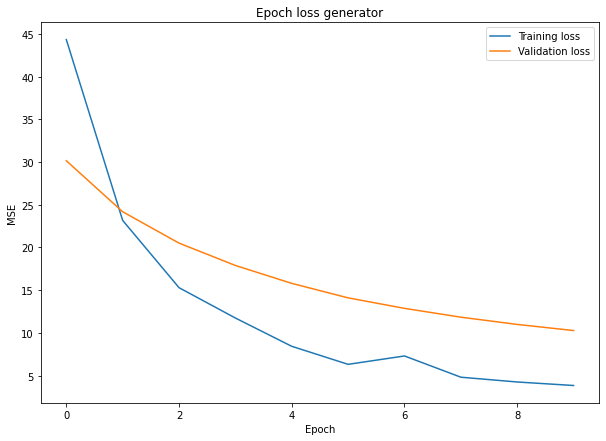

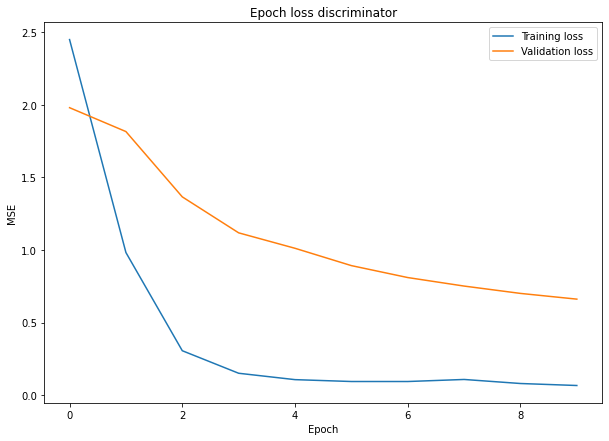

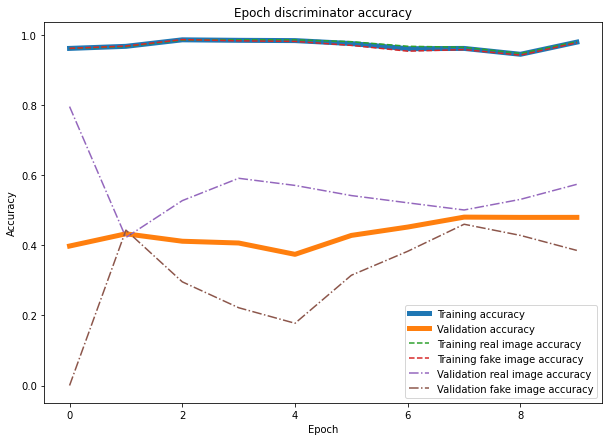

In [10]:
plt.rcParams['figure.figsize'] = [10, 7]
plt.plot(train_epoch_loss_g, label='Training loss')
plt.plot(val_epoch_loss_g, label='Validation loss')
plt.title('Epoch loss generator')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(train_epoch_loss_d, label='Training loss')
plt.plot(val_epoch_loss_d, label='Validation loss')
plt.title('Epoch loss discriminator')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(train_epoch_acc_d, label='Training accuracy', linewidth=5)
plt.plot(val_epoch_acc_d, label='Validation accuracy', linewidth=5)
plt.plot(train_epoch_acc_d_real, '--', label='Training real image accuracy')
plt.plot(train_epoch_acc_d_fake, '--', label='Training fake image accuracy')
plt.plot(val_epoch_acc_d_real, '-.', label='Validation real image accuracy')
plt.plot(val_epoch_acc_d_fake, '-.', label='Validation fake image accuracy')
plt.title('Epoch discriminator accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

9) We can test the model with 100 test data which will be saved as images

In [11]:
for batch_i in range(100):
    test_first_imgs, test_last_imgs = next(test_batch_generator)
    test_fake_last_imgs = modelObj.generator.predict(test_first_imgs) 

    test_img_name = output_log_dir + "/gen_img_test_" + str(batch_i) + ".png"
    merged_img = np.vstack((test_first_imgs[0],test_last_imgs[0],test_fake_last_imgs[0]))
    imageio.imwrite(test_img_name, img_as_ubyte(merged_img))

## EXERCISES

#### Exercise 1)
Update the network architecture given in  **build_generator**  and  **build_discriminator**  of the class GANModel. Please note that the current image resolution is set to 32x32 (i.e. IMAGE_WIDTH and IMAGE_HEIGHT values) in the file configGAN.py. 
This way initial experiements can run faster. Once you implement the inital version of the network, please set the resolution values back to 128x128. Experimental results should be provided for this high resolution images.  

**Hint:** As a generator model, you can use the segmentation model implemented in lab03. Do not forget to adapt the input and output shapes of the generator model in this case.

#### Exercise 2) 
Use different **optimization** (e.g. ADAM, SGD, etc) and **regularization** (e.g. data augmentation, dropout) methods to increase the network accuracy. 